In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
     

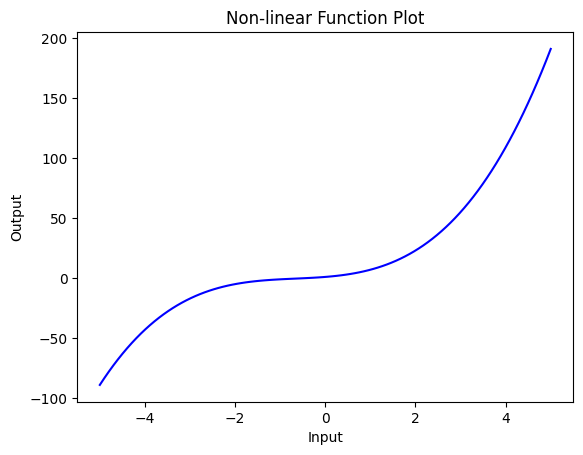

In [2]:
def non_linear_function(input_tensor):
    return (input_tensor**3 + 2*input_tensor**2 + 3*input_tensor + 1)

input_data = torch.linspace(-5, 5, 100).unsqueeze(1)
output_data = non_linear_function(input_data)

X_train = input_data.float()
y_train = output_data.float()

X_train = X_train.view(X_train.shape[0], 1)
y_train = y_train.view(y_train.shape[0], 1)

plt.plot(input_data.numpy(), output_data.numpy(), 'b')
plt.title("Non-linear Function Plot")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()


In [3]:
class NeuralNetworkModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 60)
        self.layer2 = nn.Linear(60, 40)
        self.layer3 = nn.Linear(40, 20)
        self.layer4 = nn.Linear(20, 1)
    
    def forward(self, input_tensor):
        input_tensor = F.relu(self.layer1(input_tensor))
        input_tensor = F.relu(self.layer2(input_tensor))
        input_tensor = F.relu(self.layer3(input_tensor))
        output_tensor = self.layer4(input_tensor)
        return output_tensor


In [4]:
model1 = NeuralNetworkModel()
summary(model1, (1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 60]             120
            Linear-2                   [-1, 40]           2,440
            Linear-3                   [-1, 20]             820
            Linear-4                    [-1, 1]              21
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [5]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [6]:
# Train the model
min_ratio_list = []
loss_list = []

for epoch in range(100):
    predictions = model1(X_train)
    loss = loss_function(predictions, y_train)
    optimizer.zero_grad()
    loss.backward()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch : {epoch + 1} Loss: {loss.item():.3f}')
    with torch.no_grad():
        min_ratio = float("inf")
        for param_name, param_value in model1.named_parameters():
            if not param_value.requires_grad:
                continue

            grad_vector = param_value.grad.view(-1)  # Flatten gradient
            hessian_matrix = torch.zeros((grad_vector.shape[0], grad_vector.shape[0]))

            for index, grad_value in enumerate(grad_vector):
                grad_value.requires_grad_()
                grad_output = torch.autograd.grad(grad_value, param_value, retain_graph=True, create_graph=True, allow_unused=True)[0]
                if grad_output is not None:
                    grad_output = grad_output.view(-1)
                    hessian_matrix[index] = grad_output

            eigen_values, _ = torch.linalg.eig(hessian_matrix)
            eigen_values = eigen_values.abs()
            param_min_value = param_value.abs().min().item()
            eigen_max_value = eigen_values.max().item() + 1e-7
            min_ratio = min(min_ratio, param_min_value / eigen_max_value)

        min_ratio_list.append(min_ratio)
        loss_list.append(loss.item())

    # Update model parameters
    optimizer.step()


Epoch : 10 Loss: 3754.834
Epoch : 20 Loss: 3715.211
Epoch : 30 Loss: 3649.589
Epoch : 40 Loss: 3540.352
Epoch : 50 Loss: 3364.005
Epoch : 60 Loss: 3096.479
Epoch : 70 Loss: 2720.724
Epoch : 80 Loss: 2232.341
Epoch : 90 Loss: 1662.587
Epoch : 100 Loss: 1098.171


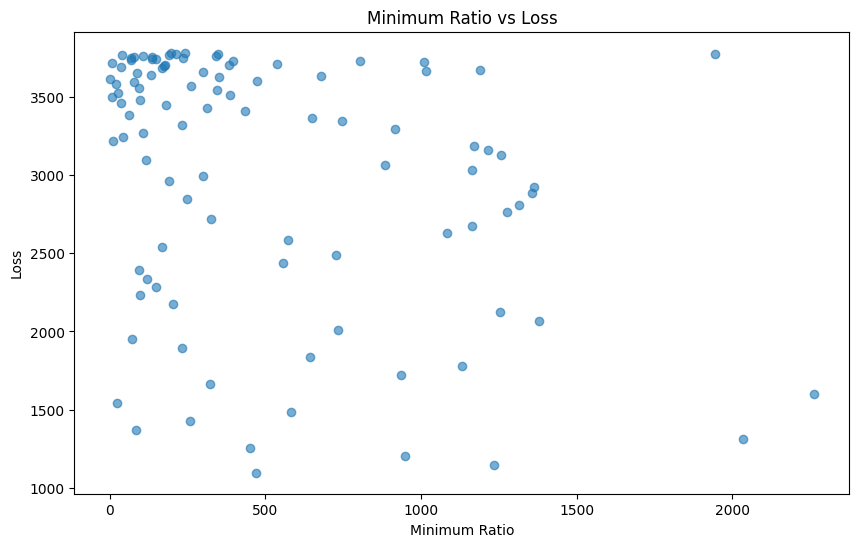

In [7]:
plot_figure = plt.figure(figsize=(10, 6))
plt.scatter(min_ratio_list, loss_list, alpha=0.6)
plt.xlabel('Minimum Ratio')
plt.ylabel('Loss')
plt.title('Minimum Ratio vs Loss')
plt.show()
